<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [2]:
# Set your student number
student_number = 400101515
Name = 'Mahdi'
Last_Name = 'Tabatabaei'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [3]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:07<00:00, 3364622.23it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197799.01it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3683884.50it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4781283.66it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [5]:
print(dataset.classes)

class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

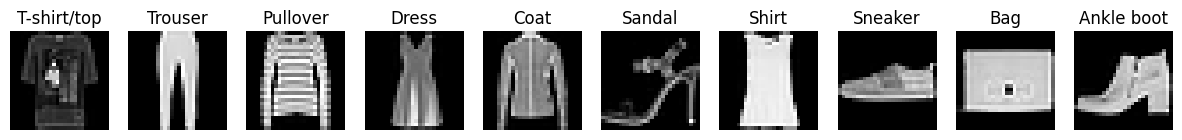

In [6]:
from torchvision.utils import make_grid
import random

# Define a function to visualize one random image from each class
def visualize_random_images_per_class(dataset):
    class_names = dataset.classes
    num_classes = len(class_names)

    # Dictionary to store one image per class
    images_per_class = {class_name: None for class_name in class_names}

    # Collect indices for each class
    class_indices = {class_name: [] for class_name in class_names}

    for idx, (image, label) in enumerate(dataset):
        class_name = class_names[label]
        class_indices[class_name].append(idx)

    # Randomly select one image per class
    for class_name in class_names:
        random_idx = random.choice(class_indices[class_name])
        images_per_class[class_name] = dataset[random_idx][0]

    # Plot the images
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))
    for ax, (class_name, image) in zip(axes, images_per_class.items()):
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(class_name)
        ax.axis('off')
    plt.show()

# Visualize random images from the training set
visualize_random_images_per_class(dataset)

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [7]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [8]:
val_frac =  0.2 # Set the fraction for the validation set
rand_seed = 42 # Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [9]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [10]:
batch_size = 32 # Set the batch size

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

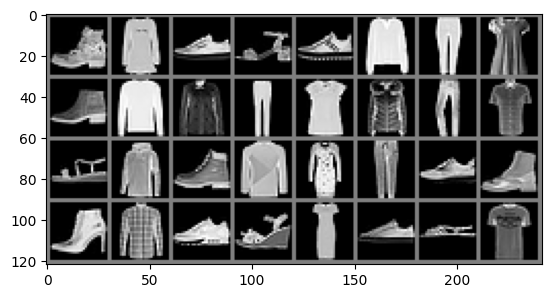

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|Ankle boot |   Shirt   |  Sneaker  |  Sandal   |  Sneaker  |   Shirt   |  Trouser  |T-shirt/top|
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|Ankle boot | Pullover  |   Shirt   |  Trouser  |   Shirt   |    Coat   |  Trouser  |   Shirt   |
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|  Sandal   | Pullover  |Ankle boot | Pullover  |   Dress   |  Trouser  |  Sneaker  |Ankle boot |
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|Ankle boot |   Shirt   |  Sneaker  |  Sandal   |   Dress   |  Sneaker  |  Sandal   |T-shirt/top|
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+


In [11]:
# Iterate over the DataLoader to get a batch of data
for images, labels in train_dl:
    # Define function to show images
    def imshow(img):
        img = img / 2 + 0.5  # Unnormalize if normalization was applied
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # Plot images in the batch
    imshow(make_grid(images))

    # Assuming class_labels and labels are defined
    labels_list = ['%5s' % class_labels[labels[j].item()] for j in range(len(labels))]

    # Create the 4x8 table by splitting the list into chunks of 8
    table = [labels_list[i:i+8] for i in range(0, len(labels_list), 8)]

    # Function to print the table with borders
    def print_table(table):
        cell_width = 11
        line = '+'.join(['-' * cell_width] * 8)
        line = f"+{line}+"

        for row in table:
            print(line)
            print('|' + '|'.join(f'{item:^{cell_width}}' for item in row) + '|')
        print(line)

    # Print the table with borders
    print_table(table)

    # Display only one batch
    break

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [12]:
!pip install torchinfo

In [13]:
# Import required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [48]:
class CustomReLU:
    def __call__(self, x):
        return torch.max(torch.tensor(0), x)

class CustomCrossEntropyLoss:
    def __call__(self, predicted, target):
        softmax = torch.exp(predicted) / torch.exp(predicted).sum(axis=1, keepdim=True)
        log_likelihood = -torch.log(softmax[range(len(softmax)), target])
        loss = log_likelihood.mean()
        return loss

class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=10):
        super(ImageClassifierNet, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(n_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)  # assuming input images are 28x28 after max pooling
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, X):
        # Define the forward pass
        X = self.pool(CustomReLU()(self.conv1(X)))
        X = self.pool(CustomReLU()(self.conv2(X)))
        X = X.view(-1, 16 * 7 * 7)  # flattening the tensor
        X = CustomReLU()(self.fc1(X))
        X = self.fc2(X)
        return X

In [60]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [50]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [32, 10]                  --
├─Conv2d: 1-1                            [32, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [32, 8, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [32, 16, 7, 7]            --
├─Linear: 1-5                            [32, 64]                  50,240
├─Linear: 1-6                            [32, 10]                  650
Total params: 52,138
Trainable params: 52,138
Non-trainable params: 0
Total mult-adds (M): 10.96
Input size (MB): 0.10
Forward/backward pass size (MB): 2.43
Params size (MB): 0.21
Estimated Total Size (MB): 2.74

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [51]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = opt_fn(model.parameters(), lr=lr)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_dl)
        train_acc = correct_train / total_train

        if len(val_dl) > 0:
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, targets in val_dl:
                    inputs, targets = inputs.to(device), targets.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                    val_loss += loss.item()

                    # Compute accuracy
                    _, predicted = torch.max(outputs, 1)
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()
            avg_val_loss = val_loss / len(val_dl)
            val_acc = correct_val / total_val

        if len(val_dl) > 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        if len(val_dl) > 0:
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [52]:
import torch.optim as optim

num_epochs = 20 # Number of training epochs
loss_fn = CustomCrossEntropyLoss() # Define the loss function
opt_fn = optim.Adam # Select an optimizer
lr = 0.001 # Set the learning rate

In [19]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/20, Train Loss: 0.5060, Train Acc: 0.8163, Val Loss: 0.3614, Val Acc: 0.8672
Epoch 2/20, Train Loss: 0.3373, Train Acc: 0.8777, Val Loss: 0.3167, Val Acc: 0.8835
Epoch 3/20, Train Loss: 0.2957, Train Acc: 0.8926, Val Loss: 0.3056, Val Acc: 0.8889
Epoch 4/20, Train Loss: 0.2711, Train Acc: 0.9009, Val Loss: 0.2826, Val Acc: 0.8938
Epoch 5/20, Train Loss: 0.2497, Train Acc: 0.9091, Val Loss: 0.2752, Val Acc: 0.8962
Epoch 6/20, Train Loss: 0.2343, Train Acc: 0.9125, Val Loss: 0.2717, Val Acc: 0.8977
Epoch 7/20, Train Loss: 0.2209, Train Acc: 0.9185, Val Loss: 0.2529, Val Acc: 0.9073
Epoch 8/20, Train Loss: 0.2079, Train Acc: 0.9228, Val Loss: 0.2665, Val Acc: 0.9028
Epoch 9/20, Train Loss: 0.1962, Train Acc: 0.9273, Val Loss: 0.2576, Val Acc: 0.9103
Epoch 10/20, Train Loss: 0.1858, Train Acc: 0.9299, Val Loss: 0.2638, Val Acc: 0.9078
Epoch 11/20, Train Loss: 0.1760, Train Acc: 0.9339, Val Loss: 0.2601, Val Acc: 0.9073
Epoch 12/20, Train Loss: 0.1665, Train Acc: 0.9372, Val Loss: 0

### Plot loss and accuracy

In [53]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

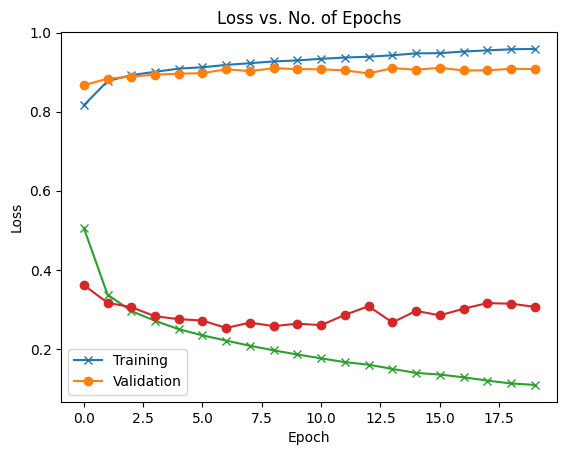

In [21]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [45]:
# Training function
def train_model_on_entire_dataset(n_epochs, model, train_dl, loss_fn, opt_fn, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = opt_fn(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_dl)
        train_acc = correct_train / total_train
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

    return model, train_losses, train_accuracies

In [54]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [61]:
num_epochs = 20 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [62]:
model, _, _, _, _ = train_model(num_epochs, model, train_dl, [], loss_fn, opt_fn, lr)

Epoch 1/20, Train Loss: 0.5279, Train Acc: 0.8084
Epoch 2/20, Train Loss: 0.3549, Train Acc: 0.8718
Epoch 3/20, Train Loss: 0.3076, Train Acc: 0.8879
Epoch 4/20, Train Loss: 0.2799, Train Acc: 0.8975
Epoch 5/20, Train Loss: 0.2597, Train Acc: 0.9058
Epoch 6/20, Train Loss: 0.2438, Train Acc: 0.9108
Epoch 7/20, Train Loss: 0.2290, Train Acc: 0.9141
Epoch 8/20, Train Loss: 0.2168, Train Acc: 0.9204
Epoch 9/20, Train Loss: 0.2049, Train Acc: 0.9241
Epoch 10/20, Train Loss: 0.1962, Train Acc: 0.9264
Epoch 11/20, Train Loss: 0.1857, Train Acc: 0.9304
Epoch 12/20, Train Loss: 0.1762, Train Acc: 0.9327
Epoch 13/20, Train Loss: 0.1690, Train Acc: 0.9375
Epoch 14/20, Train Loss: 0.1601, Train Acc: 0.9401
Epoch 15/20, Train Loss: 0.1523, Train Acc: 0.9427
Epoch 16/20, Train Loss: 0.1488, Train Acc: 0.9442
Epoch 17/20, Train Loss: 0.1400, Train Acc: 0.9475
Epoch 18/20, Train Loss: 0.1341, Train Acc: 0.9496
Epoch 19/20, Train Loss: 0.1263, Train Acc: 0.9529
Epoch 20/20, Train Loss: 0.1221, Train A

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [88]:
# Function to view predictions
def view_prediction(image, label, probabilities, class_names):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    # Display image
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[0].set_title(f'Label: {class_names[label]}')
    ax[0].axis('off')

    # Display probabilities
    y_pos = np.arange(len(class_names))
    ax[1].barh(y_pos, probabilities)
    ax[1].set_yticks(y_pos)
    ax[1].set_yticklabels(class_names)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].set_xlabel('Probability')
    ax[1].set_title('Class Probabilities')
    plt.show()

### Save the model

In [ ]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [65]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [92]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    test_acc = correct_test / total_test
    return test_acc, all_predictions, all_targets

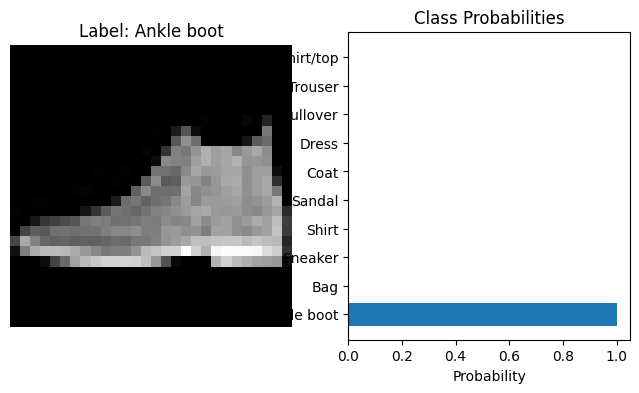

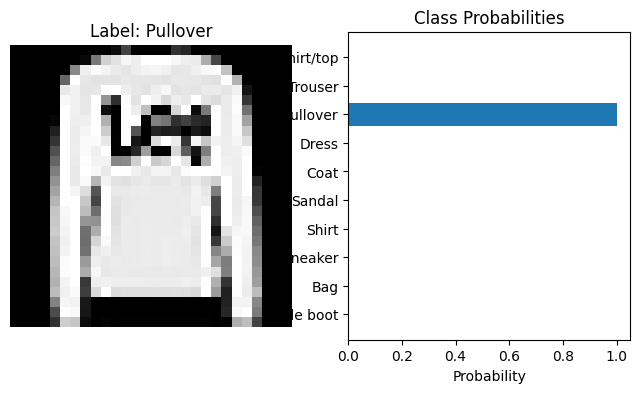

In [93]:
# Evaluate the model
acc, all_predictions, all_targets = evaluate(model, test_dl)

# Class names in FashionMNIST
class_names = dataset.classes

# Visualize a few predictions
for i in range(2):
    image, label = test_dataset[i]
    probabilities = F.softmax(torch.tensor(all_predictions[i]), dim=0).numpy()
    view_prediction(image, label, probabilities, class_names)

In [94]:
print("Test Accuracy = {:.4f}".format(acc))

Test Accuracy = 0.9030
